In [10]:
%load_ext tensorboard

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [11]:
num_classes = 2

class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        
        self.add(Conv2D(96, kernel_size=(11,11), strides=4,
                        padding='valid', activation='relu',
                        input_shape=input_shape,
                        kernel_initializer='he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),
                              padding='valid', data_format='channels_last'))
        
        self.add(Conv2D(256, kernel_size=(5,5), strides=1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),
                              padding='valid', data_format='channels_last'))
        
        self.add(Conv2D(384, kernel_size=(3,3), strides=1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        
        self.add(Conv2D(384, kernel_size=(3,3), strides=1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        
        self.add(Conv2D(256, kernel_size=(3,3), strides=1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),
                              padding='valid', data_format='channels_last'))
        
        self.add(Flatten())
        self.add(Dense(4096, activation='relu'))
        self.add(Dense(4096, activation='relu'))
        self.add(Dense(1000, activation='relu'))
        self.add(Dense(num_classes, activation='softmax'))
        
        self.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [12]:
model = AlexNet((100, 100, 3), num_classes)
model.summary()

Model: "alex_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 23, 23, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 96)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 256)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 5, 5, 384)         885120    
                                                                 
 conv2d_9 (Conv2D)           (None, 5, 5, 384)         1

In [13]:
EPOCHS = 100
BATCH_SIZE = 32
image_height = 100
image_width = 100
train_dir = 'data/catanddog/train/'
valid_dir = 'data/catanddog/validation/'

train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

train_generator = train.flow_from_directory(train_dir,
                                            target_size=(image_height, image_width),
                                            color_mode='rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode='categorical')

valid = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid.flow_from_directory(valid_dir,
                                            target_size=(image_height, image_width),
                                            color_mode='rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=7,
                                            shuffle=True,
                                            class_mode="categorical")

train_num = train_generator.samples
valid_num = valid_generator.samples

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [18]:
log_dir = "/image/log6-2/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1, profile_batch=0)

model.fit(train_generator,
          epochs=EPOCHS,
          steps_per_epoch=train_num // BATCH_SIZE,
          validation_data=valid_generator,
          validation_steps=valid_num // BATCH_SIZE,
          callbacks=[tensorboard_callback],
          verbose=1)

Epoch 1/100
12/12 [==============================] - 11s 982ms/step - loss: 0.6921 - accuracy: 0.5241 - val_loss: 0.6941 - val_accuracy: 0.4896
Epoch 2/100
12/12 [==============================] - 13s 1s/step - loss: 0.6922 - accuracy: 0.5269 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/100
12/12 [==============================] - 15s 1s/step - loss: 0.6916 - accuracy: 0.5326 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 4/100
12/12 [==============================] - 16s 1s/step - loss: 0.6920 - accuracy: 0.5269 - val_loss: 0.6931 - val_accuracy: 0.5104
Epoch 5/100
12/12 [==============================] - 18s 2s/step - loss: 0.6920 - accuracy: 0.5241 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 6/100
12/12 [==============================] - 19s 2s/step - loss: 0.6921 - accuracy: 0.5241 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 7/100
12/12 [==============================] - 17s 1s/step - loss: 0.6911 - accuracy: 0.5382 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 8/10

1/1 [==============================] - 0s 282ms/step


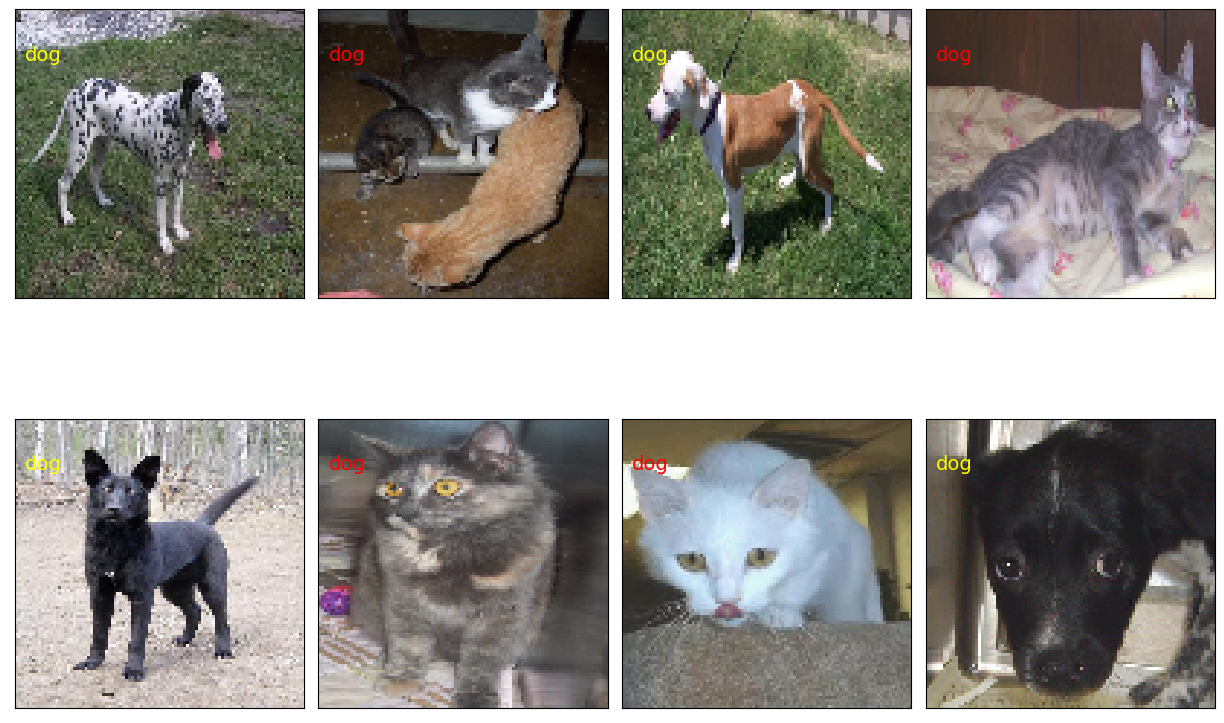

In [20]:
class_names = ['cat', 'dog']
validation, label_batch = next(iter(valid_generator))
prediction = model.predict(validation)
prediction_values = np.argmax(prediction, axis=1)

fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
    ax.imshow(validation[i,:], cmap=plt.cm.gray_r, interpolation='nearest')
    
    if prediction_values[i] == np.argmax(label_batch[i]):
        ax.text(3, 17, class_names[prediction_values[i]], color='yellow', fontsize=14)
    else:
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)

![fasfasdf](./image/log6-2/accuracy.png)